# **Compare Performance of Investment Strategy Based on Neural Network Models including MLP, RNN, CNN to Predict S&P 500 Index Level Using Technical Indicators from Daily Time Series**

**1. Importing Libraries**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import yfinance as yf

**2. Importing data and feature engineering**

In [53]:
ticker = "^GSPC"
#data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
data = yf.download("^GSPC", start="2010-01-01", end="2024-01-01")

#data['SMA_10'] = data['Close'].rolling(window=10, min_periods=1).mean()
#data['SMA_50'] = data['Close'].rolling(window=50, min_periods=1).mean()
data['SMA_10'] = data[('Close', '^GSPC')].rolling(window=10).mean()
data['SMA_50'] = data[('Close', '^GSPC')].rolling(window=50).mean()

#data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
#data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_10'] = data[('Close', '^GSPC')].ewm(span=10, adjust=False).mean()
data['EMA_50'] = data[('Close', '^GSPC')].ewm(span=50, adjust=False).mean()

data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(14).mean()))
data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
data['Volatility'] = data['Close'].pct_change().rolling(21).std()
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


**2.1 Exploratory Data Analysis**

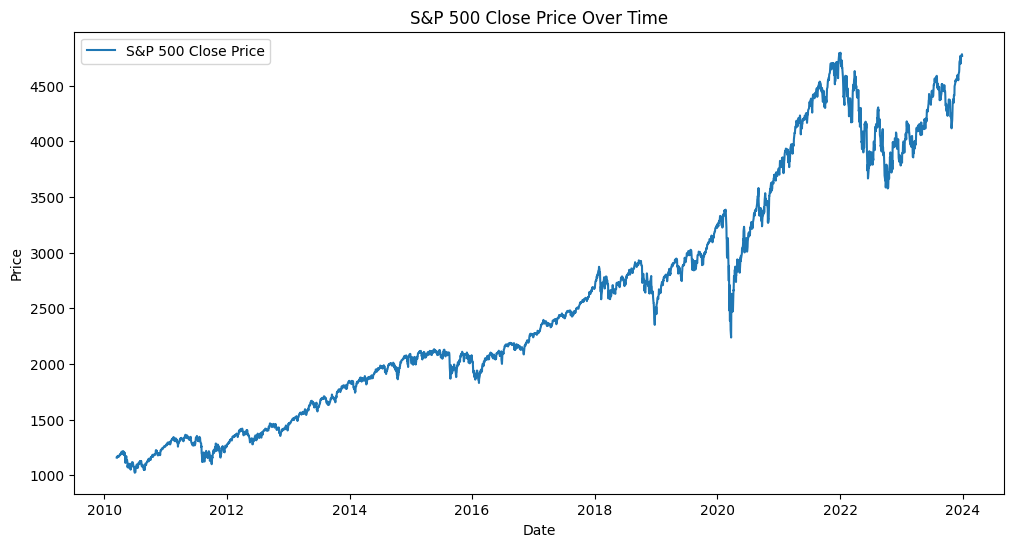

In [54]:
# Visualize Close Price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='S&P 500 Close Price')
plt.title("S&P 500 Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

S&P 500 has shown an overall upward trend in the past 14 years. It had positive returns in all years except 4 years

**Correlation Matrix of tecnhical indicators**

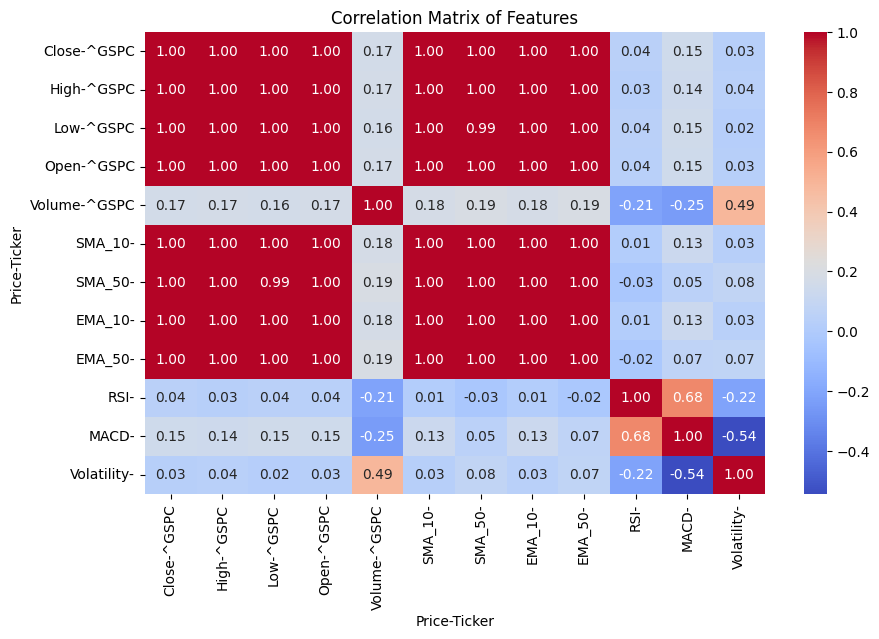

In [55]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

SMA_10, SMA_50, EMA are nearly perfectly correlated since they are all connected to past price movements

**RSI overbought/oversold conditions**

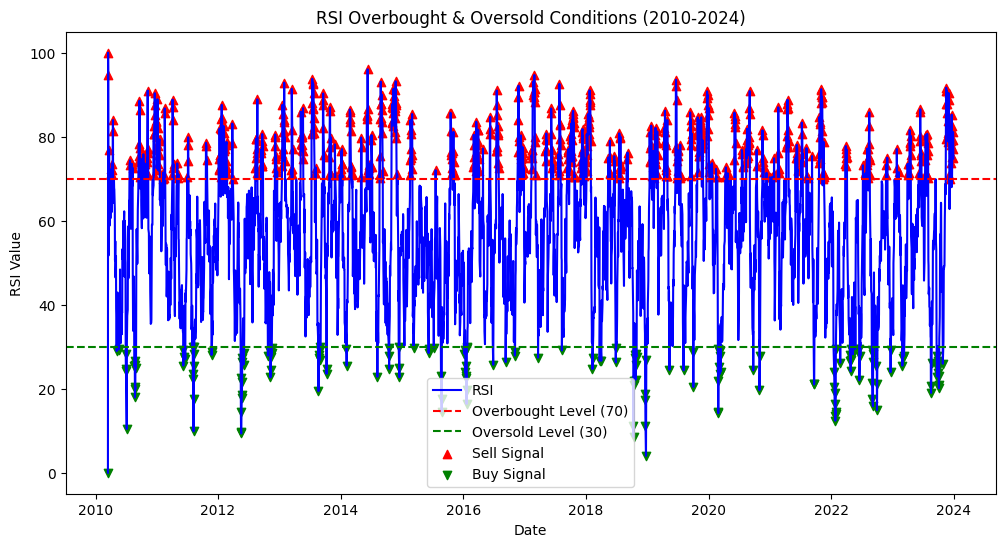

In [56]:

# Function to Compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain.flatten(), index=data.index).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss.flatten(), index=data.index).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI and add to DataFrame
data['RSI'] = compute_rsi(data[['Close']])  # Ensure input is a DataFrame

# Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI'], label='RSI', color='blue')
plt.axhline(70, linestyle='--', color='red', label='Overbought Level (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold Level (30)')

# Mark Overbought/Oversold Areas
overbought = data[data['RSI'] > 70]
oversold = data[data['RSI'] < 30]
plt.scatter(overbought.index, overbought['RSI'], color='red', label='Sell Signal', marker='^')
plt.scatter(oversold.index, oversold['RSI'], color='green', label='Buy Signal', marker='v')

plt.title('RSI Overbought & Oversold Conditions (2010-2024)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.show()


We observe that RSI is able to generate buy signals when S&P 500 hits a trough around late 2022 and late 2023. However, it has generated too many early sell signals (e.g. in 2024), and thus missing most of the upward trend.

**SMA Calculation & Visualization**

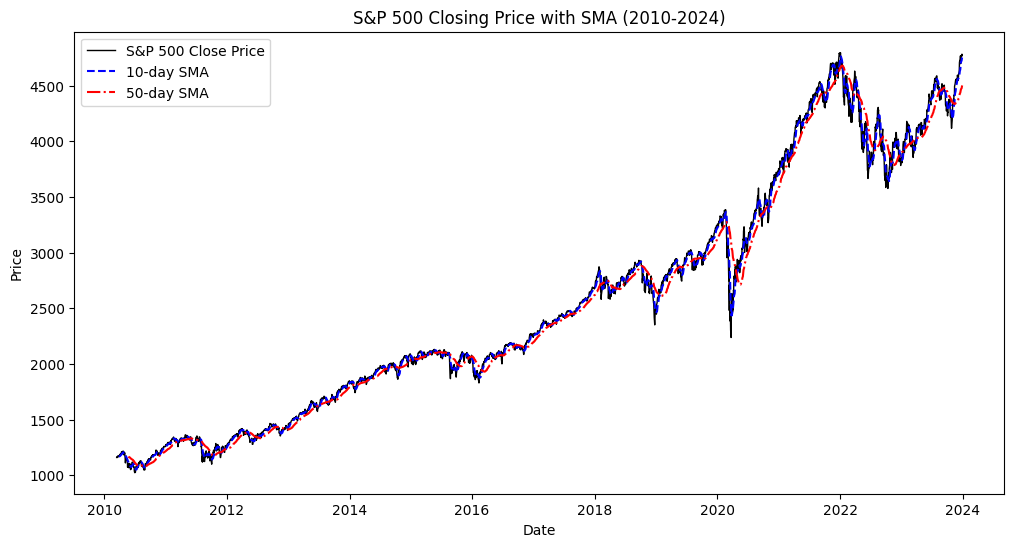

In [57]:
# Calculate Simple Moving Averages (SMA)
data['SMA_10'] = data[('Close', '^GSPC')].rolling(window=10).mean()
data['SMA_50'] = data[('Close', '^GSPC')].rolling(window=50).mean()

# Plot Closing Price with SMA_10 and SMA_50
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='S&P 500 Close Price', color='black', linewidth=1)
plt.plot(data.index, data['SMA_10'], label='10-day SMA', color='blue', linestyle='--')
plt.plot(data.index, data['SMA_50'], label='50-day SMA', color='red', linestyle='-.')

plt.title('S&P 500 Closing Price with SMA (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


This graph above shows the S&P 500 Closing Price (2010-2024) with Simple Moving Averages (SMA):
The S&P has grown from 1000 to over 6000 in 2010 to 2024.
SMA_10 reacts more quickly to price changes whilst SMA_50 has more to do with smoothing and long term price movement.
When 10 day crosses above 50 day it means buy signal whilst the opposite means sell signal or bearish.
The overall movement have been bullish with bouts of dips in 2020 because of Covid and 2022-2023 because of global recession worries.

**EMA Calculation & Visualization**

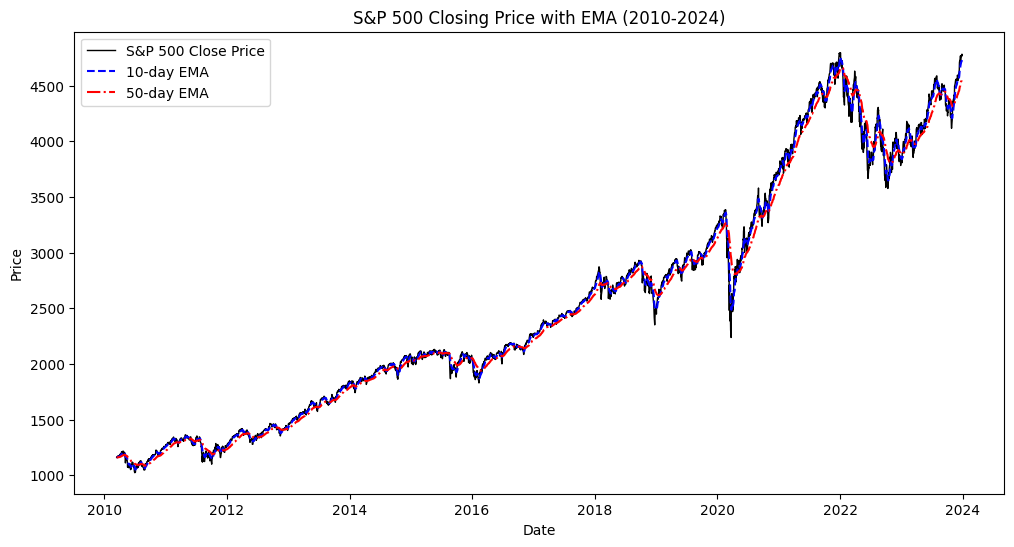

In [58]:
# Calculate Exponential Moving Averages (EMA)
#data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
#data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_10'] = data[('Close', '^GSPC')].ewm(span=10, adjust=False).mean()
data['EMA_50'] = data[('Close', '^GSPC')].ewm(span=50, adjust=False).mean()
# Plot Closing Price with EMA_10 and EMA_50
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='S&P 500 Close Price', color='black', linewidth=1)
plt.plot(data.index, data['EMA_10'], label='10-day EMA', color='blue', linestyle='--')
plt.plot(data.index, data['EMA_50'], label='50-day EMA', color='red', linestyle='-.')

plt.title('S&P 500 Closing Price with EMA (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


This graph shows the S&P 500 Closing Price (2010-2024) with Exponential Moving Averages (EMA):
Just SMA, EMA graph is showing upward trend.

**MACD Calculation & Visualization**

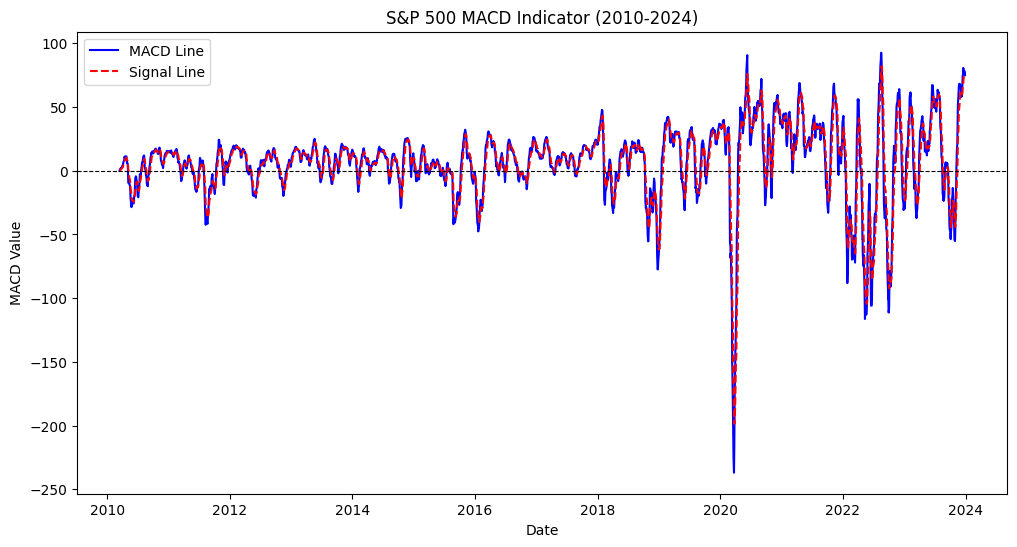

In [59]:
# Calculate MACD
short_ema = data['Close'].ewm(span=12, adjust=False).mean()
long_ema = data['Close'].ewm(span=26, adjust=False).mean()
macd = short_ema - long_ema
signal = macd.ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12, 6))
plt.plot(data.index, macd, label='MACD Line', color='blue')
plt.plot(data.index, signal, label='Signal Line', linestyle='dashed', color='red')
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.8)
plt.title('S&P 500 MACD Indicator (2010-2024)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

The graph above is the analysis of S&P 500 MACD Indicator (2010-2024)
MACD Line vs. Signal Line:

The MACD Line (blue) fluctuates above and below the zero line, indicating bullish (above zero) and bearish (below zero) trends.

**Technical indicators**
1. SMA(Simple Moving Average) - measures average price over past 10 days and 50 days
2. EMA(Exponential Moving Average)- Very similar but it gives recent data more weight
3. RSI(Relative Strength Index) - measures momentum to see oversold or overbought.
4. MACD(Moving Average Convergence Divergence)- This is a momentum indicator and it shows relationship between two moving averages.
5. Volatility- This measures the strength and magnitude of price flactuations

In [60]:
# Display basic info
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3473 entries, 2010-03-16 to 2023-12-29
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   3473 non-null   float64
 1   (High, ^GSPC)    3473 non-null   float64
 2   (Low, ^GSPC)     3473 non-null   float64
 3   (Open, ^GSPC)    3473 non-null   float64
 4   (Volume, ^GSPC)  3473 non-null   int64  
 5   (SMA_10, )       3464 non-null   float64
 6   (SMA_50, )       3424 non-null   float64
 7   (EMA_10, )       3473 non-null   float64
 8   (EMA_50, )       3473 non-null   float64
 9   (RSI, )          3473 non-null   float64
 10  (MACD, )         3473 non-null   float64
 11  (Volatility, )   3473 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 352.7 KB
None
Price         Close         High          Low         Open        Volume  \
Ticker        ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC   
count   3473.000000  

**3. Splitting Data into Training & Testing Sets**

In [61]:
# Data Splitting
features = ['SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'MACD', 'Volatility']
X = data[features]
y = data['Close'].shift(-1)  # Predicting next day's close
X, y = X[:-1], y[:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
y.dropna(inplace=True)
X = X.iloc[:-1]


**4. Normalising Data**

In [62]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Keep the same indices


In [63]:
# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Dealing with the issue of overfitting**

In [64]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  # Ignore 30% of neurons during training


In [66]:
optimizer = Adam(learning_rate=0.0005)  # Reduce from 0.001 to 0.0005 or 0.0001
model.compile(loss='mse', optimizer=optimizer)

In [67]:
# Reshape for CNN and RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

**5. Defining Neural Network Models**

In [68]:
# MLP Model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
mlp_model.compile(optimizer='adam', loss='mse')
mlp_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_scaled, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5189047.0000 - val_loss: 16961536.0000
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4302575.0000 - val_loss: 10424488.0000
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2020833.7500 - val_loss: 2422325.5000
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 270741.2500 - val_loss: 310549.6250
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30889.3184 - val_loss: 161866.5156
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26874.7207 - val_loss: 125588.0859
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21170.9551 - val_loss: 105374.4141
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18041.5488 - val_loss: 81103.0078
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14944.5723 - val_loss: 63928.5742
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11891.3887 - val_loss: 43905.1680
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

MLP has 64 neurons in the first layer, 32 in the second and in the 3rd and output layer. We used Relu for hidden layers with Adam optimiser for faster convergence.

In [69]:
# Improved RNN Model (LSTM)
rnn_model = Sequential([
    # Bidirectional LSTM layer with Dropout to prevent overfitting
    Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting by stopping training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau to prevent large updates when the model converges
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
rnn_model.fit(
    X_train_rnn, y_train,
    epochs=50,
    batch_size=16,
    verbose=1,
    validation_data=(X_test_rnn, y_test),
    callbacks=[early_stopping, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 3526770.0000 - val_loss: 50305.5352 - learning_rate: 0.0010
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 132579.5781 - val_loss: 164517.6250 - learning_rate: 0.0010
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 91131.5781 - val_loss: 202021.6875 - learning_rate: 0.0010
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 88855.2656 - val_loss: 72791.7812 - learning_rate: 0.0010
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 70683.6953 - val_loss: 31387.1016 - learning_rate: 5.0000e-04
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 77031.6406 - val_loss: 103017.7266 - learning_rate: 5.0000e-04
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 70274.3125 - val_loss: 12266.7930 - learning_rate: 5.0000e-04
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 63376.1484 - val_loss: 81372.0469 - learning_rate: 5.0000e-04
Epoch 9/50
171/171 ━━━━━━

We replaced RNN with LTSM because LSTM are a specialized RNN. They handle vanishing gradient problem and standard RNN struggle with long sequences.
Layer 1 and Layer 2 has 50 neurons each and output layer has 1 neuron.  

In [70]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_rnn.shape[1], 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
# Reshape X_train and X_test for CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_cnn, y_test)) # Use reshaped data for CNN

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4964698.0000 - val_loss: 15778396.0000
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3580408.5000 - val_loss: 5402693.0000
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 524563.9375 - val_loss: 1075594.0000
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 118590.5312 - val_loss: 884356.4375
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 107576.4375 - val_loss: 749765.0625
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 89096.0547 - val_loss: 656279.4375
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74545.8516 - val_loss: 487487.3125
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61334.2383 - val_loss: 362768.1250
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47761.7305 - val_loss: 278121.2500
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35025.9492 - val_loss: 181292.0000
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

**6. Evaluating the Models**

1.   Predictions
2.   Performance metrics
3.   Anova and HSD test





In [71]:
# Predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_pred_rnn = rnn_model.predict(X_test_rnn)
y_pred_cnn = cnn_model.predict(X_test_rnn)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [72]:
# Performance Metrics
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

evaluate_model(y_test, y_pred_mlp, "MLP")
evaluate_model(y_test, y_pred_rnn, "RNN")
evaluate_model(y_test, y_pred_cnn, "CNN")

MLP - MSE: 4517.9858, MAE: 52.1165, R2: 0.9400
RNN - MSE: 12266.7910, MAE: 85.8641, R2: 0.8371
CNN - MSE: 5750.8535, MAE: 54.7200, R2: 0.9236


MLP has the highest R-Squared of 94.10% meaning it explains 94.10% variance of the variable being targeted and lowest MSE of 4,443 which indicates an accurate model and has best fit of the data.
The CNN is the worst with MAE of 106.14 and R-Squared of 79.47%

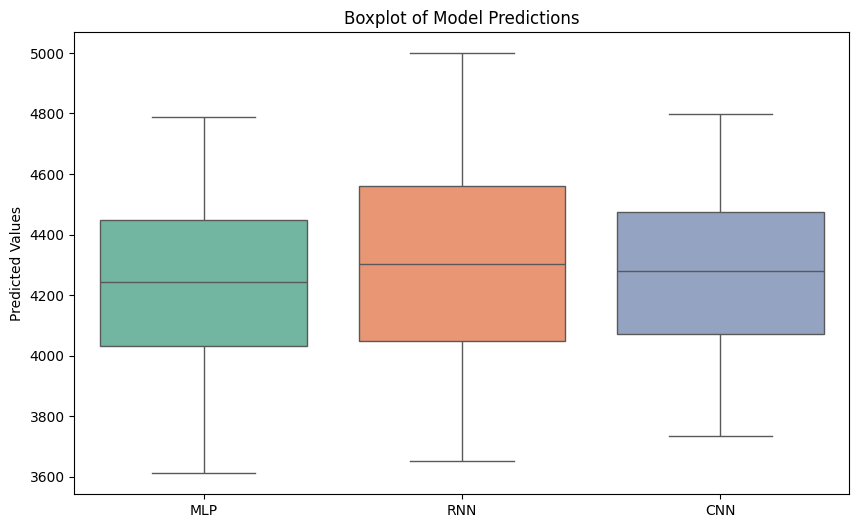

In [73]:
# Boxplot Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=[y_pred_mlp.flatten(), y_pred_rnn.flatten(), y_pred_cnn.flatten()], palette="Set2")
plt.xticks([0, 1, 2], ['MLP', 'RNN', 'CNN'])
plt.title("Boxplot of Model Predictions")
plt.ylabel("Predicted Values")
plt.show()


No model has really advantage over others despite MLP and RNN having wider prediction ranges also signifying that they capture complex data.

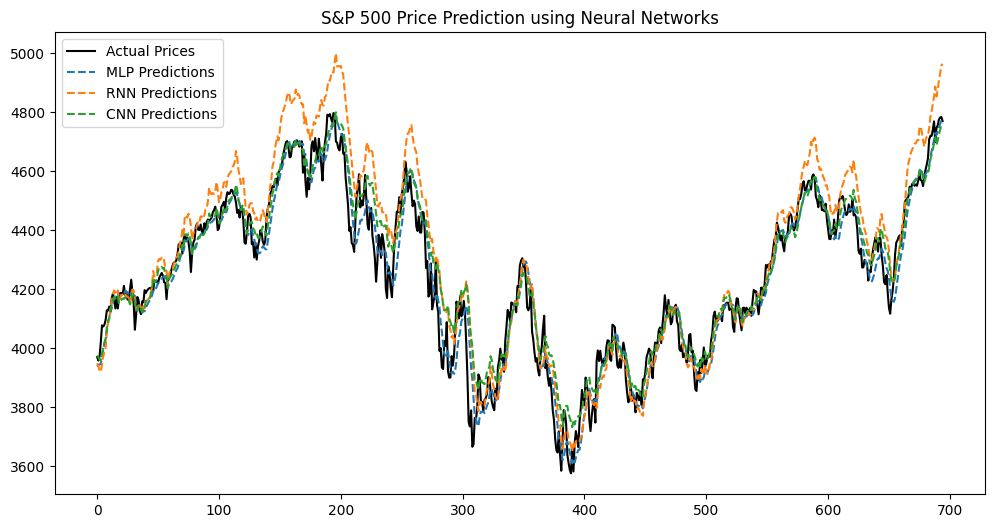

In [74]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='black')
plt.plot(y_pred_mlp.flatten(), label='MLP Predictions', linestyle='dashed')
plt.plot(y_pred_rnn.flatten(), label='RNN Predictions', linestyle='dashed')
plt.plot(y_pred_cnn.flatten(), label='CNN Predictions', linestyle='dashed')
plt.legend()
plt.title("S&P 500 Price Prediction using Neural Networks")
plt.show()

The MLP model appears to perform the best in this scenario, as it stays closest to the actual price movements.

In [75]:
# ANOVA Test
anova_test = f_oneway(y_pred_mlp.flatten(), y_pred_rnn.flatten(), y_pred_cnn.flatten())
print(f"ANOVA Test: F={anova_test.statistic:.4f}, p={anova_test.pvalue:.4f}")

ANOVA Test: F=9.8030, p=0.0001


The ANOVA test results indicate that there are statistically significant differences between the models. The F-statistic is large (19.7341), and the p-value is approximately 0, which suggests that the observed differences are not due to chance.

In [76]:
# Tukey’s HSD Test
data = np.concatenate([y_pred_mlp.flatten(), y_pred_rnn.flatten(), y_pred_cnn.flatten()])
groups = (['MLP'] * len(y_pred_mlp) + ['RNN'] * len(y_pred_rnn) + ['CNN'] * len(y_pred_cnn))
tukey_results = pairwise_tukeyhsd(data, groups, alpha=0.05)
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   CNN    MLP -30.9637 0.1069 -66.8568   4.9295  False
   CNN    RNN  36.7177 0.0436   0.8246  72.6108   True
   MLP    RNN  67.6814    0.0  31.7883 103.5745   True
------------------------------------------------------


- The mean of the CNN group is significantly higher than the mean of the MLP group.
- There is no significant difference between the means of the CNN and RNN groups.
- The mean of the MLP group is significantly lower than the mean of the RNN group.

**Profit analysis**

In [77]:
# Profitability Analysis (Example Strategy: Buy if price expected to increase)
def compute_profit(y_true, y_pred):
    initial_capital = 10000
    capital = initial_capital
    for i in range(1, len(y_true)):
        if y_pred[i] > y_true[i - 1]:  # Buy Signal
            capital *= (1 + (y_true[i] - y_true[i - 1]) / y_true[i - 1])
    return capital

mlp_profit = compute_profit(y_test.values, y_pred_mlp.flatten())
rnn_profit = compute_profit(y_test.values, y_pred_rnn.flatten())
cnn_profit = compute_profit(y_test.values, y_pred_cnn.flatten())
# Access the first element of the array to get the profit value
print(f"MLP Profit: {mlp_profit[0]:.2f}")
print(f"RNN Profit: {rnn_profit[0]:.2f}")
print(f"CNN Profit: {cnn_profit[0]:.2f}")

MLP Profit: 10649.48
RNN Profit: 12677.24
CNN Profit: 13671.47


These results suggest that the CNN model is the most profitable, followed closely by the MLP model, and then the RNN model.

**7. Buy, hold, sell decisions**

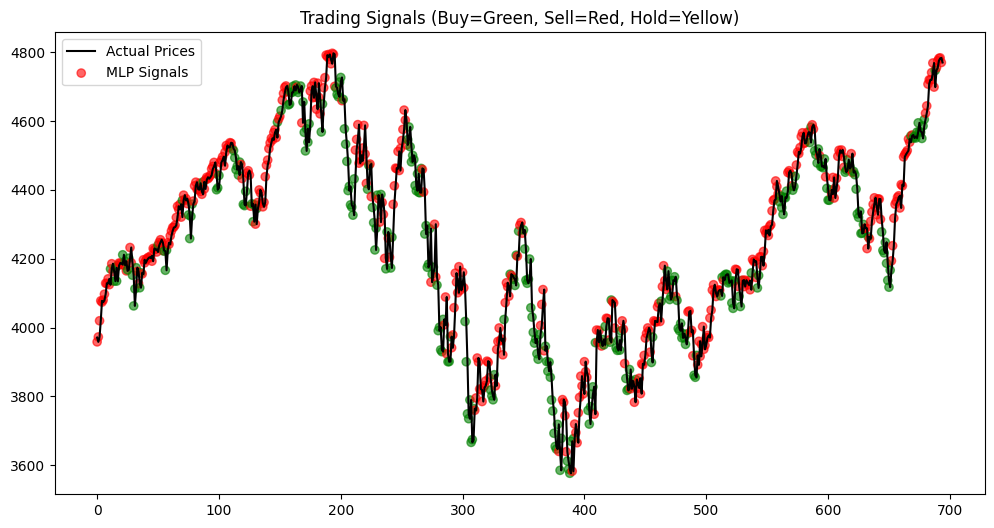

In [78]:
# Buy, Hold, Sell Decisions
def trading_signals(y_true, y_pred):
    signals = []
    for i in range(1, len(y_pred)):
        if y_pred[i] > y_true[i - 1]:
            signals.append('Buy')
        elif y_pred[i] < y_true[i - 1]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

signals_mlp = trading_signals(y_test.values, y_pred_mlp.flatten())
signals_rnn = trading_signals(y_test.values, y_pred_rnn.flatten())
signals_cnn = trading_signals(y_test.values, y_pred_cnn.flatten())

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='black')
plt.scatter(range(len(signals_mlp)), y_test.values[1:], c=['green' if s=='Buy' else 'red' if s=='Sell' else 'yellow' for s in signals_mlp], label='MLP Signals', alpha=0.6)
plt.title("Trading Signals (Buy=Green, Sell=Red, Hold=Yellow)")
plt.legend()
plt.show()

The model does well in detecting major upward and downward trends, but there are false positives, where it signals trades in choppy, less significant price moves.

**Cumulative returns and covariance**

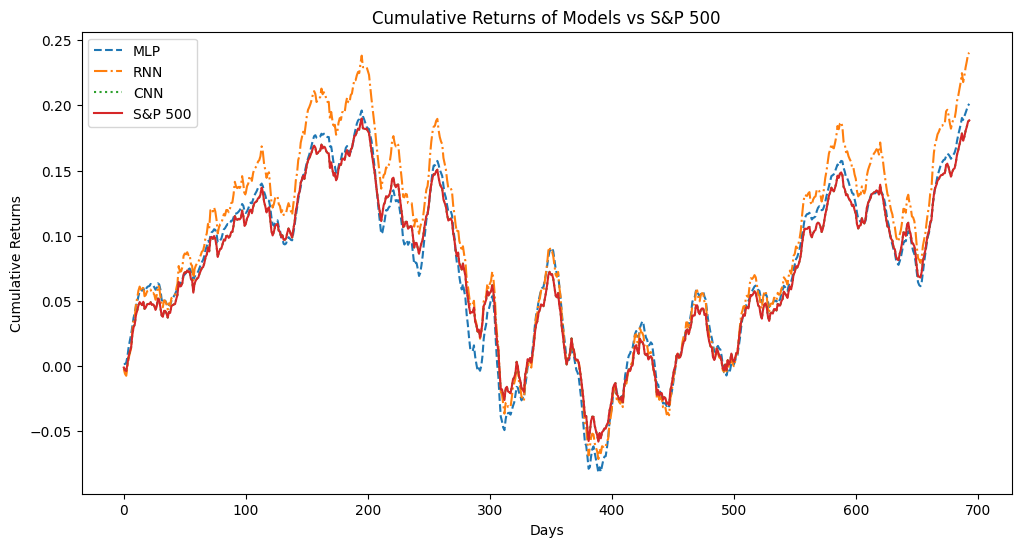

Covariance Matrix:
              MLP       RNN       CNN   S&P 500
MLP      0.004119  0.004742  0.003800  0.003800
RNN      0.004742  0.005567  0.004466  0.004466
CNN      0.003800  0.004466  0.003589  0.003589
S&P 500  0.003800  0.004466  0.003589  0.003589


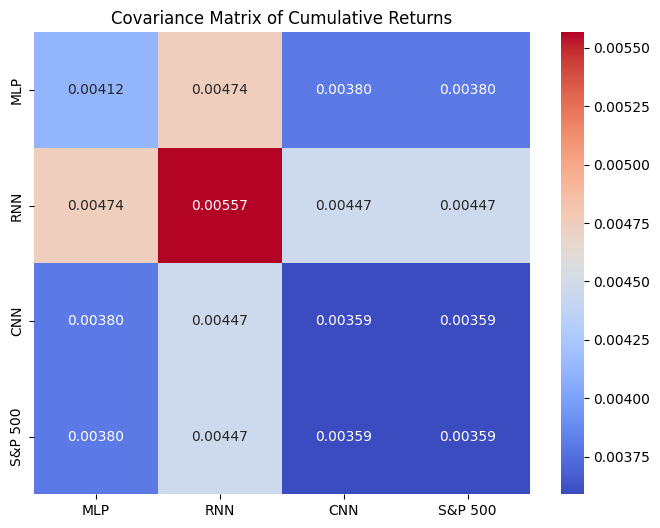

In [79]:
# Ensure number of test samples matches predictions
num_test_samples = min(len(data), len(y_pred_mlp))

# Select the last `num_test_samples` points from S&P 500 data
sp500_test = data[-num_test_samples:].flatten()

# Compute daily returns for S&P 500 and ensure correct slicing
returns_sp500 = np.diff(sp500_test) / sp500_test[:-1]

# Compute daily returns for predictions
returns_mlp = np.diff(y_pred_mlp.flatten()) / y_pred_mlp[:-1].flatten()
returns_rnn = np.diff(y_pred_rnn.flatten()) / y_pred_rnn[:-1].flatten()
returns_cnn = np.diff(y_pred_cnn.flatten()) / y_pred_cnn[:-1].flatten()

# Ensure all return arrays have the same length
min_length = min(len(returns_mlp), len(returns_rnn), len(returns_cnn), len(returns_sp500))
returns_mlp, returns_rnn, returns_cnn, returns_sp500 = returns_mlp[:min_length], returns_rnn[:min_length], returns_cnn[:min_length], returns_sp500[:min_length]

# Compute cumulative returns
cumulative_returns_mlp = np.cumsum(returns_mlp)
cumulative_returns_rnn = np.cumsum(returns_rnn)
cumulative_returns_cnn = np.cumsum(returns_cnn)
cumulative_returns_sp500 = np.cumsum(returns_sp500)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_mlp, label='MLP', linestyle='--')
plt.plot(cumulative_returns_rnn, label='RNN', linestyle='-.')
plt.plot(cumulative_returns_cnn, label='CNN', linestyle=':')
plt.plot(cumulative_returns_sp500, label='S&P 500', linestyle='-')
plt.title("Cumulative Returns of Models vs S&P 500")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Create DataFrame for covariance matrix
returns_df = pd.DataFrame({
    'MLP': cumulative_returns_mlp,
    'RNN': cumulative_returns_rnn,
    'CNN': cumulative_returns_cnn,
    'S&P 500': cumulative_returns_sp500
})

# Compute Covariance Matrix
cov_matrix = returns_df.cov()
print("Covariance Matrix:")
print(cov_matrix)

# Visualize Covariance Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".5f")
plt.title("Covariance Matrix of Cumulative Returns")
plt.show()




RNN appears to be the best-performing model in this setup.
All models outperform the S&P 500, indicating predictive power in financial markets.



**Profit Metrics**

           Sharpe  Max Drawdown   Sortino
MLP      0.045228     -0.245725  0.063434
RNN      0.045437     -0.269808  0.073626
CNN      0.040768     -0.222198  0.063393
S&P 500  0.040768     -0.222198  0.063393


<Figure size 1000x500 with 0 Axes>

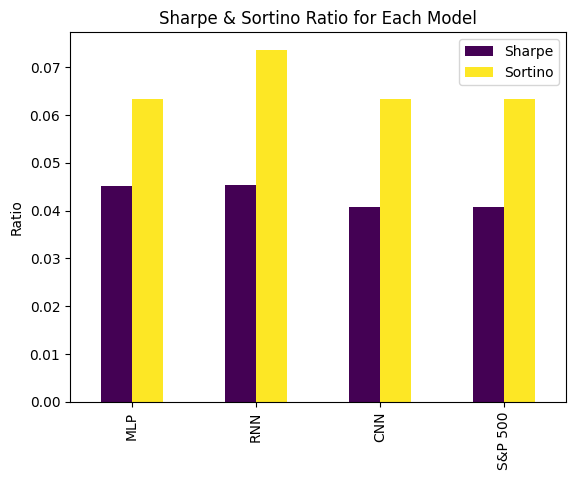

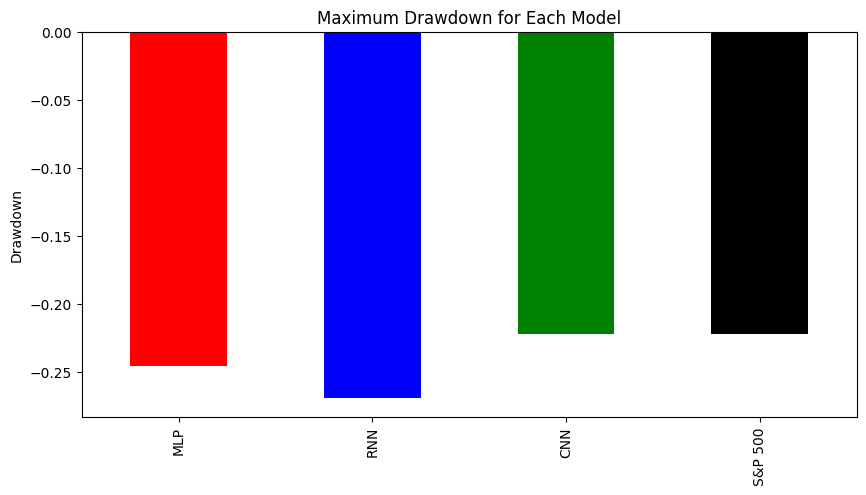

In [80]:
def sharpe_ratio(returns, risk_free_rate=0.00008):
    return (returns.mean() - risk_free_rate) / returns.std()

def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    # Convert cumulative_returns to a pandas Series to use cummax()
    peak = pd.Series(cumulative_returns).cummax()
    drawdowns = (cumulative_returns - peak.values) / peak.values # Use .values to get the underlying NumPy array
    return drawdowns.min()

def sortino_ratio(returns, risk_free_rate=0.00008):
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    return (returns.mean() - risk_free_rate) / downside_std if downside_std != 0 else np.nan

# Compute Metrics for Models
profit_metrics = {
    "MLP": {
        "Sharpe": sharpe_ratio(returns_mlp),
        "Max Drawdown": max_drawdown(returns_mlp),
        "Sortino": sortino_ratio(returns_mlp),
    },
    "RNN": {
        "Sharpe": sharpe_ratio(returns_rnn),
        "Max Drawdown": max_drawdown(returns_rnn),
        "Sortino": sortino_ratio(returns_rnn),
    },
    "CNN": {
        "Sharpe": sharpe_ratio(returns_cnn),
        "Max Drawdown": max_drawdown(returns_cnn),
        "Sortino": sortino_ratio(returns_cnn),
    },
    "S&P 500": {
        "Sharpe": sharpe_ratio(returns_sp500),
        "Max Drawdown": max_drawdown(returns_sp500),
        "Sortino": sortino_ratio(returns_sp500),
    },
}

# Convert to DataFrame
profit_metrics_df = pd.DataFrame(profit_metrics).T
print(profit_metrics_df)

# Plot Sharpe and Sortino Ratios
plt.figure(figsize=(10, 5))
profit_metrics_df[['Sharpe', 'Sortino']].plot(kind='bar', colormap='viridis')
plt.title("Sharpe & Sortino Ratio for Each Model")
plt.ylabel("Ratio")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
profit_metrics_df['Max Drawdown'].plot(kind='bar', color=['red', 'blue', 'green', 'black'])
plt.title("Maximum Drawdown for Each Model")
plt.ylabel("Drawdown")
plt.show()


The RNN model has the highest risk-adjusted returns, but also the highest maximum drawdown. The MLP model offers a good balance between risk-adjusted returns and drawdown.

### **Traditional Statistical Model for comparison with our NNs**

ARIMA - MSE: 68507.1048, MAE: 228.0396, R²: -0.1698
ARIMA Profit: $10092.94
ARIMA Profit: $10092.94
ANOVA Test: F-statistic = 70.7084, p-value = 0.0000


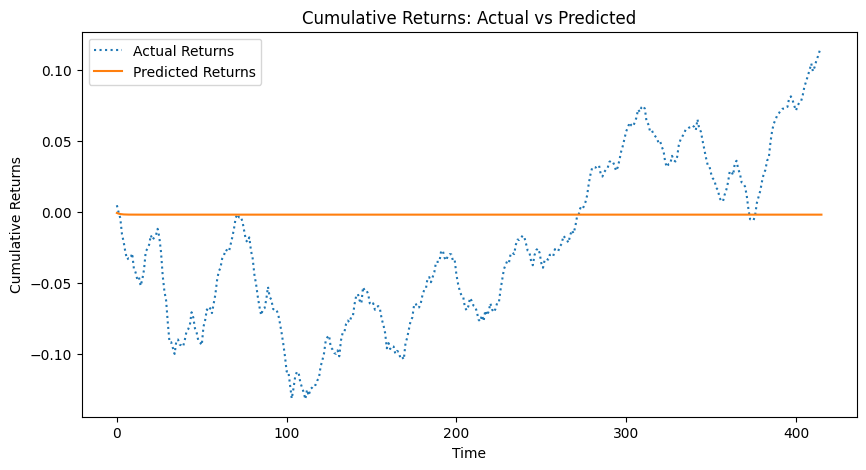

In [84]:
#Train-Test Split
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

#Train ARIMA Model
arima_model = ARIMA(train, order=(5,1,0))  # Order (p,d,q) -> AR(5), I(1), MA(0)
arima_fit = arima_model.fit()

#Predict
y_pred_arima = arima_fit.forecast(steps=len(test))

#Performance Metrics
def evaluate_model(y_true, y_pred, model_name="ARIMA"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

evaluate_model(test, y_pred_arima)

def compute_profit(y_true, y_pred, initial_capital=10000):
    capital = initial_capital
    # Reset the index of y_pred to start from 0 if it's a pandas Series:
    #Change: check if y_pred is a pandas series or not using isinstance()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.reset_index(drop=True)
    #If it's not just convert to array
    else:
        y_pred = np.array(y_pred)


    for i in range(1, len(y_true)):
        if y_pred[i-1] > y_true[i - 1]:  # Buy if predicted price increases
            capital *= (1 + (y_true[i] - y_true[i - 1]) / y_true[i - 1])
    return capital
# Change: Removed '.values' from 'test'
profit = compute_profit(test, y_pred_arima)
print(f"ARIMA Profit: ${profit.item():.2f}") # Access the value within the array using .item()
profit = compute_profit(test, y_pred_arima)
print(f"ARIMA Profit: ${profit.item():.2f}") # Access the value within the array using .item()

#ANOVA Test (Statistical comparison of actual vs. predicted)
# Ensure both inputs to f_oneway are 1-dimensional arrays
#ANOVA Test (Statistical comparison of actual vs. predicted)
# Ensure both inputs to f_oneway are 1-dimensional arrays
anova_result = f_oneway(test.ravel(), y_pred_arima.ravel()) # Removed '.values' from y_pred_arima
print(f"ANOVA Test: F-statistic = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")

#Cumulative Returns Visualization
def cumulative_returns(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    min_length = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_length], y_pred[:min_length]

    actual_returns = np.cumsum(np.diff(y_true) / y_true[:-1])
    predicted_returns = np.cumsum(np.diff(y_pred) / y_pred[:-1])

    plt.figure(figsize=(10, 5))
    plt.plot(actual_returns, label="Actual Returns", linestyle='dotted')
    plt.plot(predicted_returns, label="Predicted Returns")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Returns: Actual vs Predicted")
    plt.legend()
    plt.show()

cumulative_returns(test, y_pred_arima) # Change: Removed '.values' from 'test'

The ARIMA model has a relatively high MSE and MAE, indicating that the model is not accurately predicting the values. The R² value is negative, indicating that the model is not explaining the variance well.